In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import oledpy.dipole_emission as diem
from oledpy.dipole_emission import ThinFilmArchitecture
from matplotlib import colors
import warnings
warnings.filterwarnings('ignore')

##############################################
# 1. 데이터 로드
##############################################

# (A) PL 데이터 로드 (단일 헤더 구조)
# 파일 구조 예시: PL | wavelength_blue | abs_blue | wavelength_green | abs_green | wavelength_Red | abs_Red
pl_file_path = os.path.join("Reference Data", "tesu_lee_PL_value.xlsx")
df_pl = pd.read_excel(pl_file_path, sheet_name="Sheet1", header=0)
print("\n=== PL Data ===")
print(df_pl.head())
print("PL columns:", df_pl.columns.tolist())

# (B) NK 데이터 로드 (단일 헤더 구조)
# 파일 구조 예시: nm, TCTA_n, MoO3_n, QD_n, Ag_n, ZnO_n, TCTA_k, MoO3_k, QD_k, Ag_k, ZnO_k
nk_file_path = os.path.join("Reference Data", "tesu_lee_nk_value.xlsx")
nk_df = pd.read_excel(nk_file_path, sheet_name="Sheet1", header=0)

print("\n=== NK Data ===")
print(nk_df.head())
print("NK columns:", nk_df.columns.tolist())

# (C) NK 데이터 필수 컬럼 검증 (예: QD_n, QD_k 반드시 필요)
required_columns = ["QD_n", "QD_k"]
for col in required_columns:
    if col not in nk_df.columns:
        raise KeyError(f"{col} 컬럼 누락")



=== PL Data ===
   PL  wavelength_blue  abs_blue  wavelength_green  abs_green  wavelength_Red  \
0  24              300     0.002               390      0.002             490   
1   3              302     0.002               392      0.002             492   
2   6              304     0.002               394      0.002             494   
3   2              306     0.002               396      0.002             496   
4   3              308     0.002               398      0.002             498   

   abs_Red  
0    0.002  
1    0.002  
2    0.002  
3    0.002  
4    0.002  
PL columns: ['PL', 'wavelength_blue', 'abs_blue', 'wavelength_green', 'abs_green', 'wavelength_Red', 'abs_Red']

=== NK Data ===
   Wavelength (nm)    TCTA_n    MoO3_n      QD_n      Ag_n    ZnO_n    TCTA_k  \
0              194  1.458835  1.715435  0.546722  1.043742  1.69471  0.608817   
1              195  1.451957  1.718779  0.537730  1.048102  1.69848  0.615808   
2              196  1.448663  1.721996  0.5284

In [134]:
##############################################
# 2. 시뮬레이션 파라미터 및 PL 스펙트럼 보간
##############################################

# 관심 파장 범위 설정 (예: 300~500 nm, 5 nm 간격)
vac_wavelengths = np.arange(300, 501, 5)

# Blue PL 스펙트럼 보간 (예: 'wavelength_blue'와 'abs_blue' 컬럼 사용)
pl_spectrum_blue = np.interp(vac_wavelengths, df_pl["wavelength_blue"], df_pl["abs_blue"])
print("\nInterpolated Blue PL spectrum:")
print(pl_spectrum_blue)

# Dipole 위치 (예: 0.9, 0~1 사이)
dipole_positions = [0.9]


Interpolated Blue PL spectrum:
[0.002 0.002 0.002 0.002 0.003 0.002 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.002]


In [135]:
##############################################
# 3. 레이어 구조 정의
##############################################
# NK 데이터 컬럼과 일치하도록 레이어 이름을 설정합니다.
# 예: NK 파일에 'TCTA_n', 'MoO3_n', 'QD_n', 'Ag_n', 'ZnO_n'가 있으므로,
# 활성층(EML)은 QD 레이어로 지정합니다.
layers = [
    {'name': 'Ag',   'd': 100, 'coherent': True, 'doping': 1},        # Bottom electrode
    {'name': 'MoO3', 'd': 10,  'coherent': True, 'doping': 1},        # HIL
    {'name': 'TCTA', 'd': 35,  'coherent': True, 'doping': 1},        # HTL
    {'name': 'QD',   'd': 25,  'coherent': True, 'doping': 1, 'active': True},  # EML (활성층)
    {'name': 'ZnO',  'd': 40,  'coherent': True, 'doping': 1},        # ETL
    {'name': 'Ag',   'd': 15,  'coherent': True, 'doping': 1}         # Top electrode
]
print("\n=== Layers ===")
for lyr in layers:
    print(lyr)



=== Layers ===
{'name': 'Ag', 'd': 100, 'coherent': True, 'doping': 1}
{'name': 'MoO3', 'd': 10, 'coherent': True, 'doping': 1}
{'name': 'TCTA', 'd': 35, 'coherent': True, 'doping': 1}
{'name': 'QD', 'd': 25, 'coherent': True, 'doping': 1, 'active': True}
{'name': 'ZnO', 'd': 40, 'coherent': True, 'doping': 1}
{'name': 'Ag', 'd': 15, 'coherent': True, 'doping': 1}


In [140]:
##############################################
# 4. ThinFilmArchitecture 객체 생성 및 NK 데이터 로드
##############################################

# ThinFilmArchitecture 객체 생성
arch = ThinFilmArchitecture(
    layer_dict_list=layers,
    dipole_positions=[0.9],
    tau=1e-6,         # Exciton lifetime (예시)
    PLQY=0.95,        # PL quantum yield (예시)
    vac_wavelengths=vac_wavelengths,
    pl_spectrum=pl_spectrum_blue
)

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed


In [137]:
# NK 데이터 로드 및 활성층 지정
arch.load_nk(df_nk=nk_df)
arch.set_active_layer(3)  # 인덱스 3, 즉 layers[3]가 QD 레이어
arch.run_attribute_checks()

print("\nThinFilmArchitecture set up complete!\n")

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.

ThinFilmArchitecture set up complete!



  0%|          | 0/41 [00:00<?, ?lam/s]

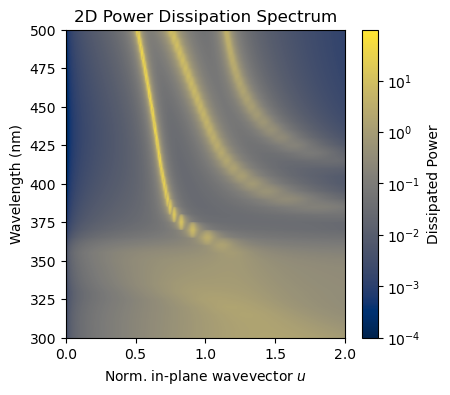

In [144]:
##############################################
# 5. Power Dissipation Spectrum 계산 및 2D 플롯
##############################################
# u (정규화된 in-plane wavevector) 그리드 생성
custom_u = np.hstack((
    np.arange(0, 0.75, 0.005),
    np.arange(0.75, 1, 0.001),
    np.arange(1+0.001, 2, 0.002),
    np.arange(2, 10, 0.1)
))
arch.init_pds_variables(custom_u=custom_u)

# 반사 및 투과 계산
arch.calc_r_and_t()

# K 데이터 계산 (광결합 상수 등)
K_data = arch.calc_K()

# u 그리드와 vac_wavelengths의 길이 일치 확인 (vac_wavelengths는 300~500nm, 간격 5nm → 41개)
u = arch.u  # custom_u
# 예시: 첫 번째 모드에 대해 power dissipation 계산: z = u * K_total (K_total[0,:,:])
z = u * K_data['K_total'][0, :, :]

# 등고선 레벨 생성 (로그 스케일)
lev_exp = np.arange(-4, np.ceil(np.log10(z.max())), 0.01)
levs = np.power(10, lev_exp)

fig, ax = plt.subplots(figsize=(4.5, 4))
cs = ax.contourf(u, vac_wavelengths, z, levs, norm=colors.LogNorm(), cmap='cividis')
ticks = 10 ** np.arange(-4, np.ceil(np.log10(z.max()) + 1), 1)
cbar = plt.colorbar(cs, ticks=ticks)
cbar.set_label('Dissipated Power')
ax.set_xlabel('Norm. in-plane wavevector $u$')
ax.set_ylabel('Wavelength (nm)')
ax.set_xlim(0, 2)
plt.title('2D Power Dissipation Spectrum')
plt.savefig(os.path.join("Plots", "power_dissipation_2d.png"), dpi=300, bbox_inches='tight')
plt.show()

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

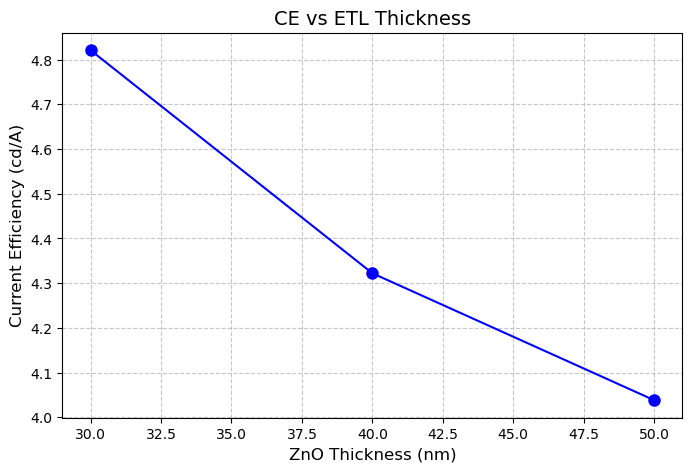

In [142]:
##############################################
# 6. ETL 두께 변화 시뮬레이션 (CE vs. ZnO Thickness)
##############################################
# 가상의 integrate_K_to_CE 함수: K_total 값을 적분해 평균내어 CE로 환산 (실제 물리 모델에 맞게 수정 필요)
def integrate_K_to_CE(K_data):
    # 예시: K_total[0,:,:]의 적분 후 평균 (단순 예시)
    return np.trapz(K_data['K_total'][0, :, :], dx=0.01).mean()

etl_results = []
for d_zn in [30, 40, 50]:
    # ETL(ZnO) 두께 변경: layers의 5번째 항목 (인덱스 4)
    layers[4]['d'] = d_zn
    
    # 새로운 구조 객체 생성
    arch_etl = ThinFilmArchitecture(
        layer_dict_list=layers,
        dipole_positions=dipole_positions,
        tau=1e-6,
        PLQY=0.95,
        vac_wavelengths=vac_wavelengths,
        pl_spectrum=pl_spectrum_blue
    )
    arch_etl.load_nk(df_nk=nk_df)
    arch_etl.set_active_layer(3)  # 활성층 지정: QD
    arch_etl.run_attribute_checks()
    
    # u 그리드 초기화
    arch_etl.init_pds_variables(custom_u=custom_u)
    arch_etl.calc_r_and_t()
    K = arch_etl.calc_K()
    
    CE = integrate_K_to_CE(K)
    etl_results.append(CE)

plt.figure(figsize=(8, 5))
plt.plot([30, 40, 50], etl_results, 'bo-', markersize=8)
plt.xlabel('ZnO Thickness (nm)', fontsize=12)
plt.ylabel('Current Efficiency (cd/A)', fontsize=12)
plt.title('CE vs ETL Thickness', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
RZ not provided. Flat RZ will be assumed
Active layer is: QD. 
 To change, call arch.set_active_layer(active_layer) Indexing starts at 0.
Provided imaginary active layer index. Discarding imaginary part.


  0%|          | 0/41 [00:00<?, ?lam/s]

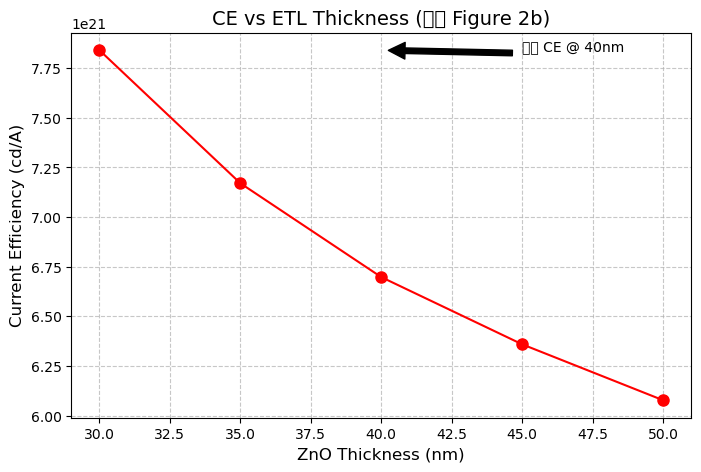

In [143]:
# 최적화된 CE 계산 함수
def integrate_K_to_CE(K_data, wavelengths, J=10):
    h = 6.626e-34  # 플랑크 상수 [J·s]
    c = 3e8        # 광속 [m/s]
    q = 1.6e-19    # 전하량 [C]
    V_lambda = 683  # 광시감도 [lm/W]
    
    # 파장별 광자 에너지 계산
    wavelengths_m = wavelengths * 1e-9  # nm → m 변환
    E_photon = h * c / wavelengths_m
    
    # K 적분 (전력 소산 → 광자 수 변환)
    total_photons = np.trapz(K_data['K_total'][0] / E_photon[:, None], 
                            x=arch.u, axis=1).sum()
    
    CE = (total_photons * V_lambda) / J  # [cd/A]
    return CE

# ETL 두께 변화 시뮬레이션 실행
etl_results = []
for d_zn in [30, 35, 40, 45, 50]:
    layers[4]['d'] = d_zn  # ZnO 두께 변경
    
    arch = ThinFilmArchitecture(
        layer_dict_list=layers,
        dipole_positions=dipole_positions,
        tau=1e-6,
        PLQY=0.95,
        vac_wavelengths=vac_wavelengths,
        pl_spectrum=pl_spectrum_blue
    )
    arch.load_nk(nk_df)
    arch.set_active_layer(3)  # 활성층 설정
    arch.init_pds_variables(custom_u=custom_u)
    arch.calc_r_and_t()
    K = arch.calc_K()
    
    CE = integrate_K_to_CE(K, vac_wavelengths)
    etl_results.append(CE)

# 그래프 플롯팅
plt.figure(figsize=(8,5))
plt.plot([30,35,40,45,50], etl_results, 'ro-', markersize=8)
plt.xlabel('ZnO Thickness (nm)', fontsize=12)
plt.ylabel('Current Efficiency (cd/A)', fontsize=12)
plt.title('CE vs ETL Thickness (논문 Figure 2b)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.annotate('최대 CE @ 40nm', xy=(40, max(etl_results)), 
             xytext=(45, max(etl_results)-1),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()


In [1]:
##############################################
# 7. 각도 종속 방출 프로파일 계산
##############################################
# 각도별 방출 프로파일 계산 (예: calc_angular_emission_profile() 함수 사용)
angular_emission = arch.calc_angular_emission_profile()  
# angular_emission: 보통 shape은 (num_angles, num_wavelengths)

# 각도 배열 (예: 0°~90°)
angles = np.linspace(0, 90, angular_emission.shape[0])

# 파장 배열은 vac_wavelengths (300~500nm)
wavelengths = vac_wavelengths

# 2D 플롯: 각도 vs 파장에 따른 방출 강도
plt.figure(figsize=(6,4))
plt.contourf(angles, wavelengths, angular_emission.T, cmap='viridis')
plt.xlabel('Viewing Angle (°)')
plt.ylabel('Wavelength (nm)')
plt.title('Angle-Dependent Emission Profile')
plt.colorbar(label='Emission Intensity')
plt.show()


NameError: name 'arch' is not defined